# IMDb Sentiment Analysis Pipeline

In [2]:
import pandas as pd

In [5]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train.csv'

# Preprocess the Text

In [17]:
import re
import string
import nltk
from nltk.corpus import stopwords

In [18]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)  
    text = text.lower()  
    text = text.split() 
    text = [word for word in text if word not in stop_words] 
    return " ".join(text)

In [20]:
df['cleaned_review'] = df['review'].apply(clean_text)
df.head(10)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...
5,"Probably my all-time favorite movie, a story o...",positive,probably time favorite movie story selflessnes...
6,I sure would like to see a resurrection of a u...,positive,sure would like see resurrection dated seahunt...
7,"This show was an amazing, fresh & innovative i...",negative,show amazing fresh innovative idea first aired...
8,Encouraged by the positive comments about this...,negative,encouraged positive comments film looking forw...
9,If you like original gut wrenching laughter yo...,positive,like original gut wrenching laughter like movi...


# Encode the Sentiment Labels

In [21]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Feature Extraction using TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_review']).toarray()
y = df['label'].values

# Train Test Split

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Model (Logistic Regression)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8919
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# Hyperparameter Tuning

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

In [28]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [29]:
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


In [30]:
from sklearn.metrics import accuracy_score, classification_report
print("Tuned Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Tuned Accuracy: 0.8923
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# Confusion Matrix & Visualization

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
cm = confusion_matrix(y_test, y_pred)

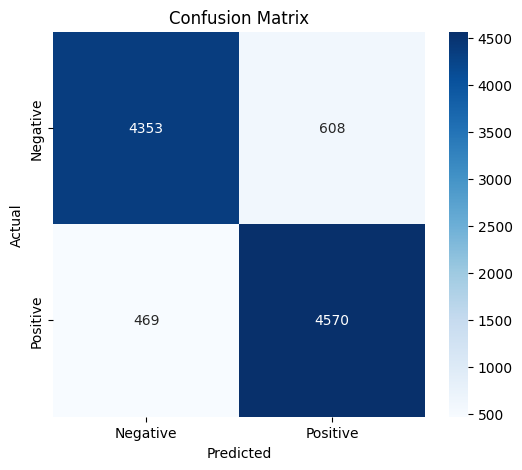

In [33]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Deep Learning Model (LSTM with Keras)

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [35]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['cleaned_review'])

In [36]:
X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])
X_pad = pad_sequences(X_seq, maxlen=200)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [38]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=10000, output_dim=64))
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

In [39]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_lstm.fit(X_train_dl, y_train_dl, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 256ms/step - accuracy: 0.7190 - loss: 0.5357 - val_accuracy: 0.8838 - val_loss: 0.2863
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 280ms/step - accuracy: 0.9177 - loss: 0.2227 - val_accuracy: 0.8864 - val_loss: 0.2846
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 284ms/step - accuracy: 0.9447 - loss: 0.1589 - val_accuracy: 0.8809 - val_loss: 0.3143
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 282ms/step - accuracy: 0.9575 - loss: 0.1215 - val_accuracy: 0.8735 - val_loss: 0.3283
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.9650 - loss: 0.1052 - val_accuracy: 0.8712 - val_loss: 0.3864


In [40]:
loss, acc = model_lstm.evaluate(X_test_dl, y_test_dl)
print(f"LSTM Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8764 - loss: 0.3618
LSTM Test Accuracy: 0.8740


# Visualize Training History (LSTM)

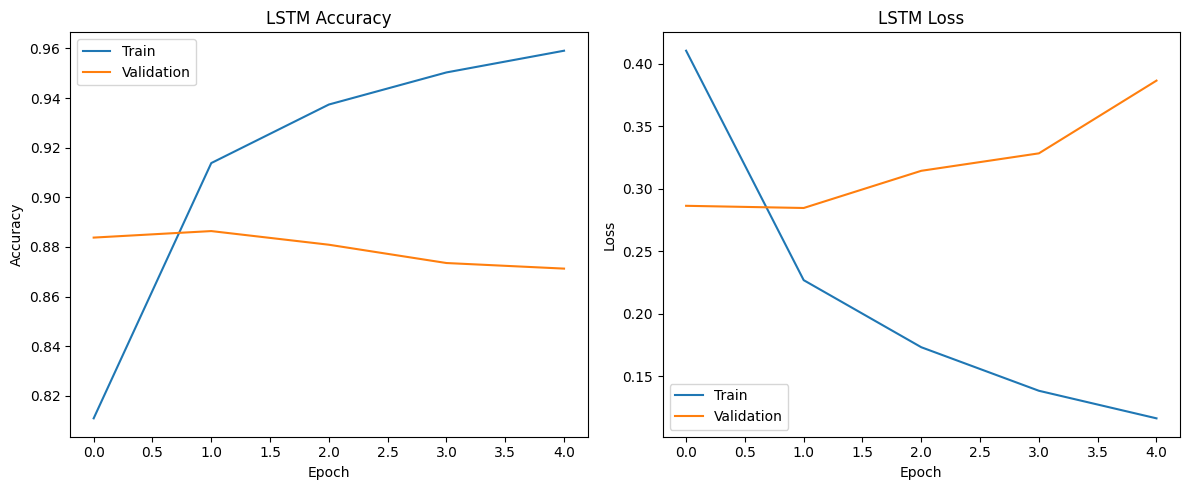

In [41]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()